In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random

In [3]:
image_size = (224, 224)
def prepare_image(image_path):
    return np.array(Image.open(image_path).resize(image_size)).flatten() / 255.0

In [4]:
X = [] # RGB converted images
Y = [] # 0 for fake, 1 for real

In [5]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    pass
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [6]:
au_path = 'D:\Google Drive\CASIA2\Au'
prepare_data(au_path, 1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
2100 2100


In [7]:
tp_path = 'D:\Google Drive\CASIA2\Tp'
prepare_data(tp_path, 0)
print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
3568 3568


In [8]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 224, 224, 3)

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [10]:
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2854 2854
714 714


In [11]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, 5, padding='valid', activation='relu', input_shape=[224, 224, 3]))
    model.add(Conv2D(32, 5, padding='valid', activation='relu', input_shape=[224, 224, 3]))
    model.add(MaxPool2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 108, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 108, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 373248)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               95551744  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [13]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

In [14]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])

In [15]:
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0,patience=2, verbose=0, mode='auto')

checkpoint_filepath = 'rgb/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

In [16]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), callbacks=[early_stopping, model_checkpoint_callback])

Epoch 1/30
90/90 [==============================] - 45s 502ms/step - loss: 0.7457 - accuracy: 0.6153 - val_loss: 0.6272 - val_accuracy: 0.6695
Epoch 2/30
90/90 [==============================] - 38s 422ms/step - loss: 0.5529 - accuracy: 0.7278 - val_loss: 0.5712 - val_accuracy: 0.7157
Epoch 3/30
90/90 [==============================] - 66s 732ms/step - loss: 0.4302 - accuracy: 0.8203 - val_loss: 0.4938 - val_accuracy: 0.7661
Epoch 4/30
90/90 [==============================] - 21s 234ms/step - loss: 0.3302 - accuracy: 0.8718 - val_loss: 0.5504 - val_accuracy: 0.7661
Epoch 5/30
90/90 [==============================] - 39s 432ms/step - loss: 0.2644 - accuracy: 0.9026 - val_loss: 0.5089 - val_accuracy: 0.7899
Epoch 6/30
90/90 [==============================] - 21s 231ms/step - loss: 0.2313 - accuracy: 0.9271 - val_loss: 0.5678 - val_accuracy: 0.7885
Epoch 7/30
90/90 [==============================] - 21s 231ms/step - loss: 0.2025 - accuracy: 0.9299 - val_loss: 0.5091 - val_accuracy: 0.7857

In [17]:
model.save('RGB_Net.h5')

In [31]:
from sklearn.metrics import average_precision_score

predictions = model.predict(X_val)
average_precision = average_precision_score(Y_val, predictions)

In [18]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve

# disp = plot_precision_recall_curve(model, X_val, Y_val)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

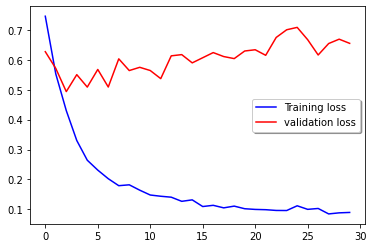

In [19]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
legend = plt.legend(loc='best', shadow=True)
plt.savefig("loss.png", bbox_inches='tight', pad_inches=0)

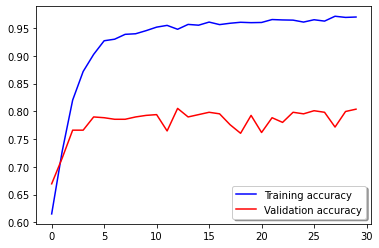

In [21]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.savefig("acc.png", bbox_inches='tight', pad_inches=0)

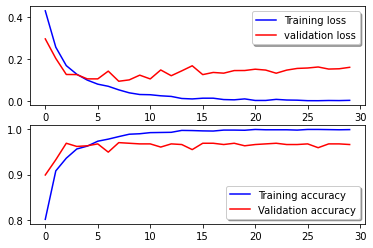

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [4]:
model = tf.keras.models.load_model('model_casia_run1.h5')

In [5]:
class_names = ['fake', 'real']

In [6]:
def predict_class(file_paths):
    for file_path in file_paths:
        image = prepare_image(file_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [12]:
fake_image_paths = ['Tp_1407_278731_138.97_198.88_314.05_553.99_person.png','Tp_71_71880_47.87_185.72_531.3_305.38_train.png']
real_image_paths = ['COCO_train2014_000000000025.jpg', '../CASIA2/Au/Au_ani_00001.jpg', '../CASIA2/Au/Au_ani_00001.jpg']

In [15]:
predict_class(real_image_paths)

Class: fake Confidence: 99.92
Class: real Confidence: 99.98
Class: real Confidence: 99.98


In [16]:
predict_class(fake_image_paths)

Class: fake Confidence: 94.43
Class: fake Confidence: 98.60


In [18]:
image = prepare_image('Tp_1407_278731_138.97_198.88_314.05_553.99_person.png')
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {y_pred_class} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: 0 Confidence: 94.43


In [20]:
y_pred.shape

(1, 2)